# Simple Localization Using TensorFlow and CUDA

## Installation Windows

* `conda create --name cuda_simple python=3.9`
* `conda config --set auto_activate_base false`
* `conda activate cuda_simple`
* `conda install -c conda-forge cudatoolkit=11.2 cudnn=8.1.0`
* `conda install -c conda-forge -y pandas jupyter`
* `python3 -m pip install -r requirements.txt`

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from utils.ui import plot_accuracy, plot_ljubljana

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
batch_size = 32
img_width = 600
img_height = 300
data_dir = "./data/ljubljana/labeled"

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.1,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.1,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

class_names = train_ds.class_names
num_of_classes = len(class_names)

Found 44168 files belonging to 71 classes.
Using 39752 files for training.
Found 44168 files belonging to 71 classes.
Using 4416 files for validation.


In [6]:
train_ds = train_ds.shuffle(32)


In [7]:
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_of_classes)
])

In [8]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 300, 600, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 300, 600, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 150, 300, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 300, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 75, 150, 32)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 150, 64)       1

In [10]:
epochs = 10
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)


Epoch 1/10
1243/1243 [==============================] - 105s 81ms/step - loss: 3.8167 - accuracy: 0.0787 - val_loss: 3.4991 - val_accuracy: 0.1282
Epoch 2/10
1243/1243 [==============================] - 106s 85ms/step - loss: 3.1241 - accuracy: 0.2073 - val_loss: 3.2969 - val_accuracy: 0.1891
Epoch 3/10
1243/1243 [==============================] - 102s 81ms/step - loss: 2.2971 - accuracy: 0.3926 - val_loss: 3.5451 - val_accuracy: 0.2217
Epoch 4/10
1243/1243 [==============================] - 103s 83ms/step - loss: 1.2865 - accuracy: 0.6427 - val_loss: 4.7806 - val_accuracy: 0.2378
Epoch 5/10
1243/1243 [==============================] - 105s 84ms/step - loss: 0.5403 - accuracy: 0.8472 - val_loss: 6.6022 - val_accuracy: 0.2373
Epoch 6/10
1243/1243 [==============================] - 105s 84ms/step - loss: 0.2305 - accuracy: 0.9335 - val_loss: 7.6829 - val_accuracy: 0.2235
Epoch 7/10
1243/1243 [==============================] - 105s 84ms/step - loss: 0.1636 - accuracy: 0.9531 - val_loss: 9

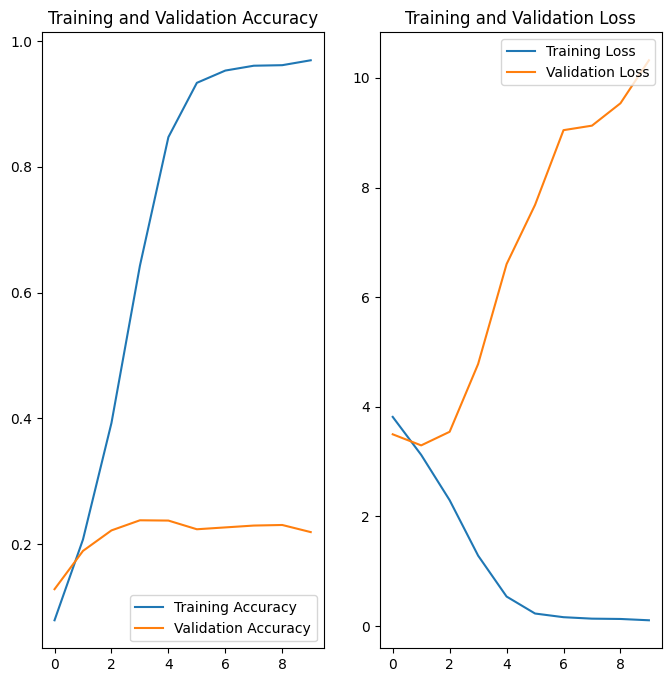

In [11]:
plot_accuracy(history, epochs)

1/1 [==============================] - 0s 15ms/step


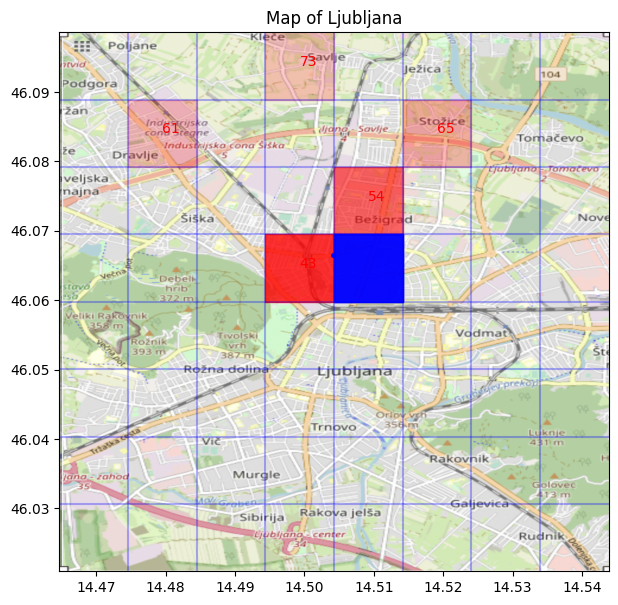

In [14]:


def normalize(arr, t_min, t_max):
    norm_arr = []
    diff = t_max - t_min
    diff_arr = max(arr) - min(arr)
    for i in arr:
        temp = (((i - min(arr))*diff)/diff_arr) + t_min
        norm_arr.append(temp)
    return norm_arr

def predict(img_name):
    img = tf.keras.utils.load_img(f"./data/ljubljana/test/{img_name}.png", target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    top5_idx = np.argsort(score)[-5:]
    top5 = [class_names[i] for i in top5_idx]
    top5scores = normalize([predictions[0][i] for i in top5_idx], 0.2, 0.8)

    img_class, img_lat, img_lng = img_name.split(",")
    actual = {
        "class": img_class,
        "y": img_lat,
        "x": img_lng
    }

    plot_ljubljana(top5, top5scores, actual, 8)

predict("4-4,46.06658374840753,14.50408403557778")

## Clear GPU Memory

In [33]:
tf.keras.backend.clear_session()